# Forces

In [37]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

from tqdm import tqdm
sys.path.insert(0, '../../../icenumerics/')
sys.path.insert(0, './../auxnumerics/')
sys.path.insert(0, '../')
import icenumerics as ice


from parameters import params
import auxiliary as aux
import montecarlo_colloids as mc
import vertices as vrt

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':11,
    'ytick.labelsize':11,
    'axes.labelsize':11,
})

In [3]:
DRIVE = '/home/frieren/BIG/'
DRIVE = '/mnt/BIG/'
PROJECT = 'reentrancy/test11'
SIZE = 10
DATA_PATH = os.path.join(DRIVE,PROJECT,str(SIZE))

In [4]:
data = pd.read_csv(os.path.join(DATA_PATH,'kappa_all.csv'))
data.t = np.round(data.t,3)
data.kappa = np.abs(data.kappa)
# get the mapping omega : max_time
maxt = {tt:dfw.t.max() for tt,dfw in data.groupby('total_time') }
# get the last frames
data_lastframes = pd.concat([data.query(f'total_time=={tt} & t=={tmax}') for tt,tmax in maxt.items()],axis=0)
# average across realizations
averaged = data_lastframes.groupby(['total_time','field','t'])['kappa'].mean().to_frame().reset_index()

In [5]:
averaged['omega'] = np.round(np.pi/2/averaged['total_time'],4)

omegas = averaged.omega.unique()
fields = averaged.field.unique()

W, B = np.meshgrid(omegas,fields)

In [6]:
rows,cols = W.shape

K = np.zeros(W.shape)
for i in range(rows):
    for j in range(cols):
        K[i,j] =  averaged.query(f'omega=={W[i,j]} & field=={B[i,j]}')['kappa'].to_numpy()[0]

K = K /4/params['size']**2

In [7]:
low = 0.3
high = 0.99

K[K<=low] = 0
K[(K>low)*(K<=high)] = 0.5
K[K>high] = 1

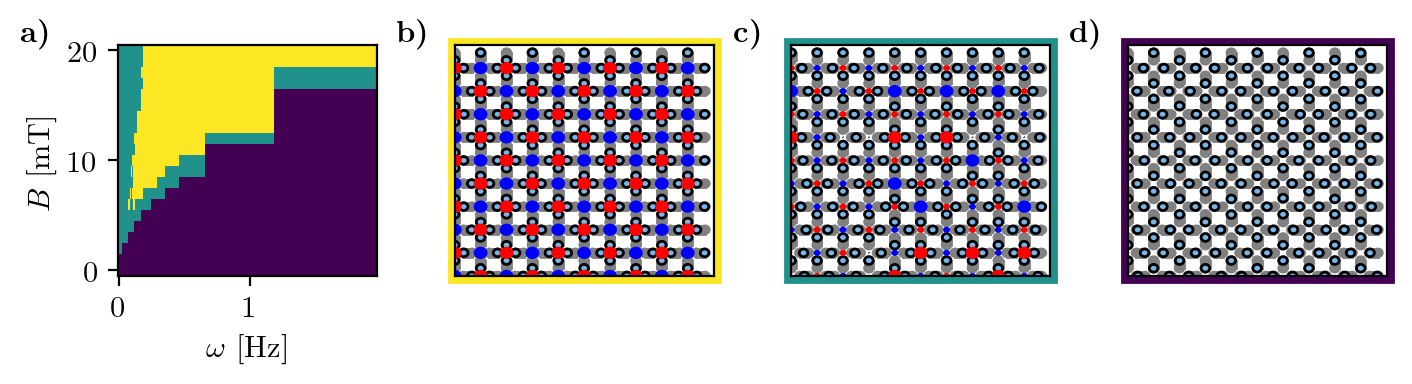

In [121]:
COL=510/72
OFFSET=(510-444.728)/72
OFFSET=1.1

labels = ['\\textbf{a)}',
          '\\textbf{b)}',
          '\\textbf{c)}',
          '\\textbf{d)}']

fig = plt.figure(figsize=(COL+OFFSET, 1.5),dpi=200)
gs = gridspec.GridSpec(1, 4, hspace=0, wspace=0.3)

size = fig.get_size_inches()
aspect_ratio = size[1]/size[0]
    
ax = fig.add_subplot(gs[0])
norm = plt.Normalize(0,1)
cmap = plt.get_cmap('viridis')

colors = [cmap(norm(i)) for i in [1,0.5,0]]

c = ax.pcolormesh(W, B, K, norm=norm, cmap=cmap, rasterized=True)
ax.set_xlabel('$\\omega$ [Hz]',fontsize=11)
ax.set_ylabel('$B$ [mT]',fontsize=11)

position = ax.get_position()
x,y,w,h = (position.x0, position.y0, position.width, position.height)

fig.text(x-0.06,y+h+0.01,labels[0], fontsize=11)

# =================================================
# PLOTTING THE TRAJECTORIES
# =================================================

# pairs of total_time and field value
times = [10, 1000, 1]
fields = [15, 20, 10]

times_str = list(map(str, times))
fields_str = list(map(lambda x: str(x)+'mT',fields))

for i, (tt,field) in enumerate(zip(times_str, fields_str)):
    
    # define the ax obj from the gridspec
    ax = fig.add_subplot(gs[i+1])

    # load the trj and vertices object
    trj = ice.trajectory(os.path.join(DATA_PATH,tt,field,'xtrj1.csv'))
    v = trj.get_vertices(os.path.join(DATA_PATH,tt,field,'vertices1.csv'))
    trj.load()
    
    # get the last common frame between the trj and the vertices
    frame = int(np.min([trj.trj.index.get_level_values('frame').values[-1], v.vertices.index.get_level_values('frame').values[-1]]))
    
    # plotting both trj and vertices
    ice.draw_frame(trj.trj, frame_no=frame,
               region=[0,300,0,300],
               radius=params['particle_radius'].magnitude,
               cutoff=params['trap_sep'].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               square=False,
               ax=ax)
    v.display(ax,sl=frame)
    
    conditions = f'${np.pi/2/times[i]:.3f}$ Hz, {fields[i]} mT '
    #ax.set_title(conditions)

    # dealing with the background boxes
    position = ax.get_position()
    x,y,w,h = (position.x0, position.y0, position.width, position.height)
    pad = 0.02
    
    rect = patches.Rectangle(
        (x - aspect_ratio*pad, y - pad), 
        w + 2*aspect_ratio*pad, 
        h + 2*pad, 
        color=colors[i], 
        alpha=1, 
        transform=fig.transFigure, 
        zorder=0
    )
    fig.add_artist(rect)

    fig.text(x-0.035,y+h+0.01,labels[i+1],fontsize=11)

# ==========================================================================================================
# COLORBAR
# ==========================================================================================================

#fig.subplots_adjust(bottom=0.25)
#fig.subplots_adjust(left=0.2)

#cbar_ax = fig.add_axes([0.2, 0.05, 0.7, 0.01])  # [left, bottom, width, height]
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#sm.set_array([])
#
#cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#cbar.ax.tick_params(labelsize=10)
#
#custom_ticks = [0,1]
#cbar.set_ticks(custom_ticks)
#cbar.set_ticklabels(custom_ticks)
#
#fig.text(0.15, 0.05, '$\\kappa$', fontsize=10, ha='center', va='center')


fig.savefig('/home/frieren/Dropbox/mnt/martensitepaper/fig6.pdf',dpi=300,bbox_inches='tight')
fig.savefig('/home/frieren/Dropbox/mnt/martensitepaper/fig6.png',dpi=300,bbox_inches='tight')

plt.show()

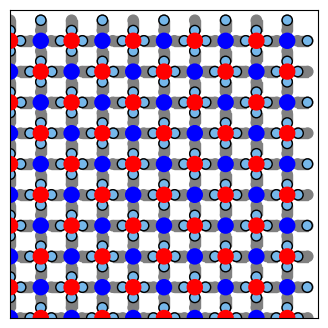

In [55]:
fig, ax = plt.subplots(figsize=(4,4))
tt,field = '10','15mT'
trj = ice.trajectory(os.path.join(DATA_PATH,tt,field,'xtrj1.csv'))
v = trj.get_vertices(os.path.join(DATA_PATH,tt,field,'vertices1.csv'))

trj.load()
frame = trj.trj.index.get_level_values('frame').unique().max()
ice.draw_frame(trj.trj, frame_no=frame,
           region=[0,300,0,300],
           radius=params['particle_radius'].magnitude,
           cutoff=params['trap_sep'].magnitude/2,
           particle_color='#75b7ea',
           trap_color='gray',
           ax=ax)
v.display(ax,sl=frame)


['15mT', '20mT', '3mT']

In [61]:
last_common_frame = int(np.min([trj.trj.index.get_level_values('frame').values[-1], v.vertices.index.get_level_values('frame').values[-1]]))

199